# 论文名：Deep reinforcement learning for universal quantum state preparation via dynamic pulse control

## 论文链接：https://doi.org/10.1140/epjqt/s40507-021-00119-6

## 项目介绍

原论文提出，采用深度强度学习中的 DQN (deep Q network) 算法，可在满足给定实际物理的硬件限制条件下，设计最佳控制脉冲，实现量子态重置任务：将任意单或双量子比特态重置到指定目标态上。本项目基于 MindSpore 机器学习和 MindQuantum 量子计算框架对其算法和核心结果进行复现，对原代码进行优化整合，以实现在社区上更好的开源效果及算法推广。本项目可作为经典深度强化学习与量子系统相交互产生最优控制的典型案例。

## 要点概述：
量子态的重置在量子信息处理中是一个很重要的任务。譬如，在基于量子线路算法中，在计算任务开始前，需要先将每个量子比特重置到基态 $|0\rangle$ 上；对于一个简单的二值量子随机数生成器，在测量以得到随机数前，需要将量子比特重置到叠加态 $(|0\rangle + |1\rangle)/\sqrt{2}$ 上。等等。

不同的物理系统，要实现量子态重置任务，对应的控制脉冲是截然不同的，需要依据物理限制，专门进行设计。比如，在单-三重态 ($S-T_0$) 编码的半导体双量子点中，单个量子比特的哈密顿量为：
$$ H_{1-qubit}=J(t)\sigma_z + h\sigma_x,$$

其中，$\sigma_z$ 和 $\sigma_x$ 分别导致了量子态在布洛赫球上沿 $z$- 和 $x$-轴的转动。而其前因子表明了各自的旋转速度。而实验上，$J(t)$ 由电极产生的静电场控制，可快速改变，但取值要求必须为非负的有限值，以免破坏系统的电荷结构，造成泄露。而 $h$ 由临近量子比特放置的磁石的磁场导致，很难变化，在量子门时间尺度内，可认为是常数。此处设为 1，并将其作为动作 $J(t)$ 的强度单位。将约化普朗克常数 $\hbar$ 设为 1，并将 $1/\hbar$ 作为时间标度。

态重置任务为，通过设计时序脉冲 $J(t)$ 控制任意量子初态，使其最终达到给定的目标态。量子态可由布洛赫球上的由参数 $\theta\in[0,\pi]$ 和 $\varphi\in[0,2\pi)$ 确定的一个点来表示：
$$s = |\psi\rangle=\cos(\frac{\theta}{2})|0\rangle+\mathrm{e}^{i\varphi}\sin(\frac{\theta}{2})|1\rangle.$$

![Bloch_sphere.jpg](./src/Bloch_sphere.jpg)

本文关于 $J(t)$ 的时序脉冲优化方案为：
![pulses_designing.jpg](./src/pulses_designing.jpg)

先从数据集中选取一个样本作为态重置任务的初态 $s_{init}$，并将步数 $k$ 设为 1； 

将初态输入到主网络 Main Net $\theta$ （深度强化学习 DQN 中的主网络：其输入为当前时刻量子态 $s$ 的实数序列描述（为便于神经网络处理，将原本为复向量表示的量子态实数化为实向量，如对于量子态 `np.array([a+bi, c+di])` 实数化之后为状态 `np.array([a,c,b,d])`）输出为该所有可能动作 $a$（即为 $J(t)$ 的值）的预测 Q 值）中。根据主网络的输出 Q 值，可选择最大 Q 值所对应的动作作为当前动作 $a_k$；

将动作 $a_k$ 加入到时序控制脉冲序列中。

根据选定的动作，量子模拟系统按时间演化算符将当前时刻量子态演化到下一时刻量子态 $s'$，并得出标志着下一时刻量子态与目标量子态 $s_{tar}$ 之间相似程度的保真度 $F$。

$$s'=\mathrm{exp}(-iH(a_k)\mathrm{d}t),$$
$$F=|\langle s_{tar}|s'\rangle|^2.$$

将下一时刻量子态作为新的当前时刻量子态 $s\leftarrow s'$，并将步数 $k+1$。

将新的量子态 $s$ 重新实数化并输入到主网络中，再次得到新的动作、下一时刻量子态···

重复此循环，直到保真度达到阈值要求，或者总步数 $k$ 超过限制。

最终的控制脉冲序列由该过程中得到的动作序列截取而成，截取点为整个过程中保真度达到最大值的位置。

原论文结果表明，在采用足够多随机初始态训练神经网络后，神经网络可以为任何量子态制定出最佳动作，这些动作缀连起来，即为最佳控制方案。

例如，下图为神经网络针对量子初态 $\theta=2/7\pi$， $\varphi=3/7\pi$ 设计的时序脉冲。

![pulses.jpg](./src/pulses.jpg)

在此时序脉冲控制下，对应的量子态在布洛赫球面上的运动轨迹为：

![state_trajectory.jpg](./src/state_trajectory.jpg)

主网络的训练过程依照 DQN 算法进行，如下图所示：
![DQN.jpg](./src/DQN.jpg)

为训练、验证、和测试网络，我们在布洛赫球表面沿角度均匀选取了 128 个 点作为初态，构成初态集，并将其按 1:1:2 的比例随机划分为训练集、验证集和测试集。

算法的神经网络部分由 Mindspore 搭建，而量子系统的模拟则依托 Mindquantum 框架。

## 复现内容一：$S-T_{0}$ 编码的半导体双量子点模型中，单量子比特态重置任务。
目标态为基态 $|0\rangle$。

导入所需依赖项

In [1]:
import copy
import random
from time import *
import numpy as np
from mindquantum import *
from collections import deque
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mindspore import dataset as ds
from mindspore.common.initializer import Normal
from mindspore import Model, Tensor, context, nn, set_seed
context.set_context(mode=context.GRAPH_MODE, device_target="CPU") # 设置静态图模式，CPU 支持此模式
from src import Single_qubit_QSR_via_DRL

[WARNING] ME(787343:139915937793344,MainProcess):2023-10-17-18:47:10.691.18 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


设置随机数种子，便于调试。设置泡利矩阵，后面用于构建系统哈密顿量。

In [2]:
set_seed(1) # 设置宏观随机数种子

sx = X.matrix().astype(np.complex128) # 定义泡利算符，根据 mindquantum 基本门的 matrix() 功能来得到矩阵形式
sz = Z.matrix().astype(np.complex128)
si = I.matrix().astype(np.complex128)

dt = np.pi/10

智能体离散动作空间为：

In [3]:
action_space = [0,1,2,3]

基于 Mindspore 定义神经网络。

In [4]:
# 定义训练网络：
class LinearNet(nn.Cell):
    def __init__(self):
        super(LinearNet, self).__init__() # 网络： 两个隐藏层，分别有 32/32 个神经元；输出层 4 个神经元。
        self.fc1 = nn.Dense(4, 32, Normal(0.02), Normal(0.02), True, "relu")
        self.fc2 = nn.Dense(32, 32, Normal(0.02), Normal(0.02), True, "relu")
        self.fc3 = nn.Dense(32, 4, Normal(0.02), Normal(0.02), True, "relu") 

    def construct(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q_values = self.fc3(x)
        return q_values

net = LinearNet()

构造智能体包括创建模型、记忆库、定义动作选择、处理训练样本等功能。

In [5]:
# 定义智能体，所有动作选择、网络训练等任务都由其完成。
class Agent(nn.Cell):
    def __init__(self,
            n_actions=4,
            n_features=4,
            learning_rate=0.0001,
            reward_decay=0.9,
            e_greedy=0.99,
            replace_target_iter=250,
            memory_size=2000,
            batch_size=32,
            e_greedy_increment=None):
        super(Agent, self).__init__()
        self.n_actions = n_actions # 允许的分立动作数
        self.n_features = n_features # 用实向量描述量子态所需维度
        self.lr = learning_rate # 神经网络的学习率
        self.gamma = reward_decay # 奖励折扣因子
        self.epsilon_max = e_greedy # 执行动态贪心算法进行动作选择时，采用网络来预测动作的最大概率 epsilon
        self.epsilon_increment = e_greedy_increment # 动态贪心算法 epsilon 的每次增幅
        self.epsilon = 0 if self.epsilon_increment is not None else self.epsilon_max
        self.replace_target_iter = replace_target_iter # 目标网络更新间隔：每训练主网络 replace_target_iter 次，就更新一次目标网络。
        self.batch_size = batch_size # 训练批数据尺寸
        self.learn_step_counter = 0 # 记录训练次数，每 replace_target_iter 次学习, 更新 target 网络参数一次
        self.memory_size = memory_size # 记忆库容量上限
        self.memory = deque(maxlen=self.memory_size) # 容量有限的记忆库
        self.memory_counter = 0 # 记忆库存储次数。用于初期判断是否可以开始对主网络进行训练
        self.main_net = Model(net, nn.loss.MSELoss(), nn.RMSProp(params=net.trainable_params(), learning_rate=self.lr)) # 主网络
        self.target_net = self.main_net # 目标网络

    def store_transition(self, s, a, r, s_): # 保存 经验单元
        self.memory.append([s, a, r, s_])
        self.memory_counter += 1

    def choose_action(self, state, tanxin): # tanxin 的值代表着 预测动作的 策略选择
        # tanxin = 0 意味着完全随机取动作
        # tanxin = 0.5 意味着执行动态贪心策略
        # tanxin = 1 意味着完全靠网络选择动作

        if tanxin == 0: # tanxin = 0, 意味着完全随机选动作
            action = np.random.randint(0, self.n_actions)
        elif tanxin == 1: # tanxin = 1, 意味着全靠网络预测动作, 通常在测试阶段用 # 其他值的话就意味着动作选择概率处于动态调整中, 比如 tanxin = 0.5
            action = np.argmax(self.main_net.predict(Tensor([state])))
        else:
            if np.random.uniform() < self.epsilon:
                action = np.argmax(self.main_net.predict(Tensor([state])))
            else:
                action = np.random.randint(0, self.n_actions)

        return action

    # 采集数据。
    def get_samples(self, s_batch, Q):
        for i in range(len(s_batch)):
            yield s_batch[i], Q[i]

    # 根据采集到的数据，生成训练数据
    def get_train_data(self, s_batch, Q):
        train_data = ds.GeneratorDataset(list(self.get_samples(s_batch, Q)),column_names=['state','Q'])
        train_data = train_data.batch(self.batch_size) # 进行批处理
        return train_data

    def learn(self):
        if self.learn_step_counter % self.replace_target_iter == 0: # 每 replace_target_iter 次学习, 更新 target 网络参数一次
            self.target_net = self.main_net # target 网络参数从 主网络完全复制而来

        if self.memory_counter < self.batch_size: # 只有当 记忆库中的数据量 比 批大小 多的时候才开始学习
            return # 如果 if 成立, 那么 return 后面的 且与 if 同级的代码不再执行
        batch_memory = random.sample(self.memory, self.batch_size) # 从 记忆库 中随机选出 批大小 数量的样本
        s_batch = np.array([replay[0] for replay in batch_memory]).astype(np.float32) # 多行数组
        Q = self.main_net.predict(Tensor(s_batch)) # 主网络预测 Q 值

        next_s_batch = np.array([replay[3] for replay in batch_memory]).astype(np.float32)
        Q_next = self.target_net.predict(Tensor(next_s_batch)) # 目标网络预测下一时刻状态的 Q 值

        # 使用公式更新训练集中的 Q 值
        for i, replay in enumerate(batch_memory):
            _, a, reward, _ = replay
            Q[int(i)][int(a)] =   reward + self.gamma * max(Q_next[i]) # Q 值计算法则

        train_data = self.get_train_data(s_batch, Q)
        self.main_net.train(1, train_data, dataset_sink_mode=False) # 训练一次网络

        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

依托 MindQuantum 构建量子系统的时间演化算符:$$\mathrm{e}^{-i[J(t)\sigma_z+\sigma_x]\mathrm{d}t}.$$

In [6]:
def _matrix(coeff):
    # expm(-1j*(coeff*sz+sx)*dt)
    f = np.sqrt(1 + coeff**2)
    theta = f * dt
    return np.cos(theta) * si - 1j * np.sin(theta) * (coeff / f * sz +
                                                      1 / f * sx)


def _diff_matrix(coeff):
    f = np.sqrt(1 + coeff**2)
    theta = f * dt
    m = np.cos(theta) * si - 1j * np.sin(theta) * (coeff / f * sz + 1 / f * sx)
    return -1j * dt * m @ sz

Evo = gene_univ_parameterized_gate('U', _matrix, _diff_matrix) # 给定动作的时间演化算符
circ = Circuit()+Evo('coeff').on(0) # 将时间演化算符作为量子门编到线路中
circ = circ.as_encoder()
ham = Hamiltonian(QubitOperator("")) # 定义一个空的哈密顿量，用于后面求解两个量子态之间的保真度

定义环境，包括量子态集合、重置为量子初态、step 执行动作功能。

In [11]:
# 模拟量子系统作为交互环境
class env():
    def  __init__(self,
        action_space = [0,1], #允许的动作，默认两个分立值，只是默认值，真正值由调用时输入
        ):
        self.action_space = action_space
        self.n_actions = len(self.action_space)
        self.n_features = 4 #描述状态所用的长度
        self.target_psi =  np.array([1,0]) #最终的目标态为 |0>,  np.array([1,0,0,0])
        self.training_set, self.validation_set, self.testing_set = self.psi_set()

    # 生成训练集、验证集和测试集
    def psi_set(self):
        theta_num = 6 # 除了 0 和 Pi 两个点之外，点的数量
        varphi_num = 21 # varphi 角度一圈上的点数
        # 总点数为 theta_num * varphi_num + 2(布洛赫球两极) # 6 * 21 + 2 = 128

        theta = np.linspace(0,np.pi,theta_num+2,endpoint=True)
        varphi = np.linspace(0,np.pi*2,varphi_num,endpoint=False)

        psi_set = []
        for ii in range(1,theta_num+1):
            for jj in range(varphi_num):
                psi_set.append(np.array([np.cos(theta[ii]/2),np.sin(theta[ii]/2)*(np.cos(varphi[jj])+np.sin(varphi[jj])*(0+1j))]).astype(np.complex64))

        psi_set.append(np.array([1,0]).astype(np.complex64)) # 最后再加上 |0> 和 |1> 两个态
        psi_set.append(np.array([0,1]).astype(np.complex64))

        random.shuffle(psi_set) # 打乱点集

        # 数据集切割
        training_set = psi_set[0:32]
        validation_set = psi_set[32:64]
        testing_set = psi_set[64:128]

        return training_set, validation_set, testing_set


    def reset(self, sim, init_psi): # 在一个新的回合开始时，归位到开始选中的那个点上
        sim.set_qs(init_psi)
        init_state = np.array([init_psi[0].real, init_psi[1].real, init_psi[0].imag, init_psi[1].imag])
        # np.array([1实，2实，1虚，2虚])

        return sim, init_state


    def step(self, sim, sim_target, action, nstep):
        fid_ops = sim.get_expectation_with_grad(ham, # 单位算符，除了占位，啥用也没有。因为要计算的是两个量子态之间的保真度
                                                circ, # 右线路，由时间演化算符所定义。用于根据当前时刻量子态计算下一时刻量子态
                                                Circuit(), # 左线路，空的。保持目标态不变
                                                sim_target, # 目标量子态
                                                parallel_worker=1) # 并行核
        fid_list, _ = fid_ops(np.array([[action]])) # action 整数
        fid = np.abs(fid_list[0,0])**2
        sim.apply_circuit(circ, pr=action)
        psi_ = sim.get_qs()
        state_ = np.array([psi_[0].real, psi_[1].real, psi_[0].imag, psi_[1].imag])

        err = 10e-4
        rwd = fid
        done = (((1 - fid) < err) or nstep >= 2 * np.pi / dt) # 用于判断智能体是否停止当前任务

        return sim, state_, rwd, done, fid

设置神经网络的训练方案：每个回合随机抽选出训练集中的一个量子态作为态重置任务的初态，对网络进行训练。在每一个回合的训练后，都利用验证集验证训练效果。当达到很好的训练效果时，即可停止训练。经过尝试，发现训练 30 余个回合后，网络即可达到很好的收敛效果，验证集平均态重置保真度达到 0.99 以上。

In [12]:
# 训练过程
def training(ep_max):
    training_set = env.training_set
    validation_set = env.validation_set

    sim = Simulator('mqvector', 1)
    sim_target = Simulator('mqvector', 1)
    sim_target.set_qs(env.target_psi) # 设置目标量子态
    print('--------------------------')
    print('训练中...')
    for i in range(ep_max):
        if i % 5 == 0:
            print('当前训练回合为：', i)
        training_init_psi = random.choice(training_set)
        fid_max = 0

        sim, observation = env.reset(sim, training_init_psi)
        nstep = 0

        while True:
            action = agent.choose_action(observation, 0.5)
            sim, observation_, reward, done, fid = env.step(sim, sim_target, action, nstep)
            nstep += 1
            fid_max = max(fid_max, fid)
            agent.store_transition(observation, action, reward, observation_)
            agent.learn()
            observation = observation_

            if done:
                break

        if i % 1 == 0: # 每 x 个回合用验证集验证一下效果，动作全靠网络，保存最大保真度和最大奖励
            validation_fid_list = []
            validation_reward_tot_list = []
            for validation_init_psi in validation_set:
                validation_fid_max = 0
                validation_reward_tot = 0

                sim, observation = env.reset(sim, validation_init_psi)
                nstep = 0

                while True:
                    action = agent.choose_action(observation, 1)
                    sim, observation_, reward, done, fid = env.step(sim, sim_target, action, nstep)
                    nstep += 1
                    validation_fid_max = max(validation_fid_max, fid)
                    validation_reward_tot = validation_reward_tot + reward * (agent.gamma ** nstep)
                    observation = observation_

                    if done:
                        break
                validation_fid_list.append(validation_fid_max)
                validation_reward_tot_list.append(validation_reward_tot)

            validation_reward_history.append(np.mean(validation_reward_tot_list))
            validation_fid_history.append(np.mean(validation_fid_list))

            print('本回合验证集平均保真度: ', np.mean(validation_fid_list))
            # print('本回合验证集平均总奖励: ', np.mean(validation_reward_tot_list))

设置测试过程。用测试集中的每个量子态作为初态，进行态重置操作，得到每个任务的最大保真度。

In [13]:
def testing(): # 测试 测试集中的点 得到 保真度 分布
    print('\n测试中, 请稍等...')

    testing_set = env.testing_set
    fid_list = []

    sim = Simulator('mqvector', 1)
    sim_target = Simulator('mqvector', 1)
    sim_target.set_qs(env.target_psi) # 设置目标量子态

    for test_init_psi in testing_set:
        fid_max = 0
        sim, observation = env.reset(sim, test_init_psi)
        nstep = 0

        while True:
            action = agent.choose_action(observation, 1)
            sim, observation_, reward, done, fid = env.step(sim, sim_target, action, nstep)
            nstep += 1
            fid_max = max(fid_max, fid)
            observation = observation_

            if done:
                break

        fid_list.append(fid_max)

    return fid_list

主函数部分。设置网络超参数、调用之前所定义的各个函数，完成训练、验证和测试功能。

--------------------------
训练中...
当前训练回合为： 0


[ERROR] CORE(787343,7f40b7c54540,python):2023-10-17-18:49:02.531.249 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_787343/2609019936.py]
[ERROR] CORE(787343,7f40b7c54540,python):2023-10-17-18:49:02.531.280 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_787343/2609019936.py]


本回合验证集平均保真度:  0.6068312350730591


[ERROR] CORE(787343,7f40b7c54540,python):2023-10-17-18:49:03.542.758 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_787343/2609019936.py]
[ERROR] CORE(787343,7f40b7c54540,python):2023-10-17-18:49:03.542.780 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_787343/2609019936.py]


本回合验证集平均保真度:  0.6068312350730591
本回合验证集平均保真度:  0.6068312350730591
本回合验证集平均保真度:  0.6068312350730591
本回合验证集平均保真度:  0.6068312350730591
当前训练回合为： 5
本回合验证集平均保真度:  0.6068312350730591
本回合验证集平均保真度:  0.6068312350730591
本回合验证集平均保真度:  0.9267987508031817
本回合验证集平均保真度:  0.6529863855673063
本回合验证集平均保真度:  0.6529863855673063
当前训练回合为： 10
本回合验证集平均保真度:  0.7592394434066753
本回合验证集平均保真度:  0.8086158476234135
本回合验证集平均保真度:  0.7592394434066753
本回合验证集平均保真度:  0.906605220345573
本回合验证集平均保真度:  0.7592394434066753
当前训练回合为： 15
本回合验证集平均保真度:  0.7936752559506203
本回合验证集平均保真度:  0.8219691162992111
本回合验证集平均保真度:  0.661546933082353
本回合验证集平均保真度:  0.943676941181013
本回合验证集平均保真度:  0.7806087308953387
当前训练回合为： 20
本回合验证集平均保真度:  0.865312781566525
本回合验证集平均保真度:  0.7694571502465604
本回合验证集平均保真度:  0.9430155517913568
本回合验证集平均保真度:  0.7696332645119188
本回合验证集平均保真度:  0.952326712287779
当前训练回合为： 25
本回合验证集平均保真度:  0.9285831511292202
本回合验证集平均保真度:  0.9361864278352772
本回合验证集平均保真度:  0.9774957448019416
本回合验证集平均保真度:  0.8761044016328793
本回合验证集平均保真度:  0.981052

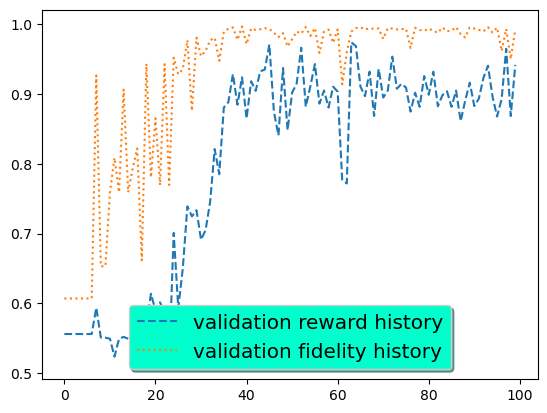


测试中, 请稍等...
测试集平均保真度为： 0.9941049423870252


In [14]:
if __name__ == "__main__":
    env = env(action_space = list(range(4)) # 离散动作空间
             )

    agent = Agent(env.n_actions, env.n_features,
              learning_rate = 0.01,
              reward_decay = 0.9,
              e_greedy = 0.95,
              replace_target_iter = 200,
              memory_size = 20000,
              e_greedy_increment = 0.001)

    validation_reward_history = []
    validation_fid_history = []

    begin_training = time()

    # 训练模块 此模块可反复利用
    training(ep_max = 100)

    end_training = time()

    training_time = end_training - begin_training

    print('\n训练过程共用时：',training_time,"s")

    print('各验证回合回合奖励记录为: ', validation_reward_history)
    print('各验证回合最大保真度记录为: ', validation_fid_history)

    # 绘出训练过程中的表现
    x = np.arange(len(validation_reward_history))
    fig, ax = plt.subplots()
    ax.plot(x,np.array(validation_reward_history)/7,'--',label='validation reward history')
    ax.plot(x,validation_fid_history,':',label='validation fidelity history')
    legend = ax.legend(loc='lower center', shadow=True, fontsize='x-large')
    legend.get_frame().set_facecolor('#00FFCC')
    plt.show()

    # 测试
    testing_fid_list = testing()
    print('测试集平均保真度为：', np.mean(testing_fid_list))

设置图片显示模式

In [2]:
%matplotlib inline

从 src 调用执行整个程序。

--------------------------
训练中...
当前训练回合为： 0
当前训练回合为： 5
当前训练回合为： 10
当前训练回合为： 15
当前训练回合为： 20
当前训练回合为： 25
当前训练回合为： 30
当前训练回合为： 35
当前训练回合为： 40
当前训练回合为： 45
当前训练回合为： 50
当前训练回合为： 55
当前训练回合为： 60
当前训练回合为： 65
当前训练回合为： 70
当前训练回合为： 75
当前训练回合为： 80
当前训练回合为： 85
当前训练回合为： 90
当前训练回合为： 95

训练过程共用时： 608.3375852108002 s
各验证回合回合奖励记录为:  [4.175625962519177, 4.175625962519177, 4.175625962519177, 4.175625962519177, 4.175625962519177, 4.175625962519177, 4.340426272820771, 4.175625962519177, 4.175625962519177, 4.340426272820771, 4.340426272820771, 4.175625962519177, 4.121161668029059, 4.294844031738709, 4.806787463805563, 4.340426272820771, 4.603480614575207, 5.21050871478581, 5.301465955047613, 5.1085805981107075, 5.453512558822263, 5.549395116084066, 5.512082223419281, 6.0073441249287765, 5.870274335358338, 5.686409158245174, 6.018097916677939, 5.793621584118853, 5.553584428764384, 5.319741666838746, 5.498045420741095, 5.552086446407839, 5.37532974080635, 5.753819486534199, 5.859220000462178, 5.850643000985055

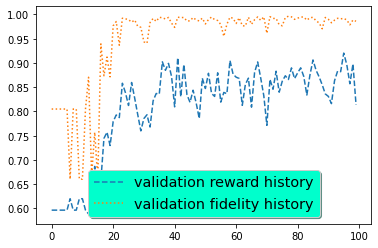


测试中, 请稍等...
测试集平均保真度为： 0.9847300273604254


<Figure size 432x288 with 0 Axes>

In [5]:
%run ./src/Single-qubit_QSR_via_DRL.py 

此即为原文图 2(a)。可见，在此模型下复现结果和原文中一致。

## 复现内容二： $S-T_0$ 编码的半导体双量子点模型中，电场耦合下双量子比特态重置任务。

目标态为 Bell 态 $|00\rangle + |11\rangle /\sqrt{2}$。

在基底 $\{|SS\rangle,|ST_0\rangle,|T_0S\rangle, |T_0T_0\rangle\}$ 下，系统的哈密顿量为：

$$
	H_{2-qubit}=\frac{\hbar}{2}
	\left(\begin{array}{cccc}
    J_{1}+J_{2} & h_{2}           & h_{1}           & 0                          \\
    h_{2}           & J_{1}-J_{2} & 0               & h_{1}                      \\
	h_{1}           & 0               & J_{2}-J_{1} & h_{2}                      \\
	0               & h_{1}           & h_{2}           & -J_{1}-J_{2}+2J_{12}
  \end{array}\right),
$$

其中，$h_i$ 和 $J_i$ 分别第 $i$ 个量子比特的塞曼能级差和交换耦合。和单量子比特情形相同，要求 $J_i>0$，而 $h$ 为常数。这里，我们将 $J_i$ 作为智能体的动作，而将 $h_i$ 的值设为 1. $J_{12}\propto J_1J_2 $ 为两个比特之间的库伦耦合强度。这里，我们将其设为  $J_{12}=J_1J_2/2$ 。

允许的动作空间为：

 $$\{(J_1,J_2)|J_1,J_2 \in\{1, 2, 3, 4, 5 \}\}.$$ 

此处态重置任务是将任意一个双量子比特态，经过时序脉冲控制之后，重置到给定的目标态 Bell 态 $|00\rangle + |11\rangle /\sqrt{2}$ 上。
而任意双量子比特态的定义为：

$$\{\left[a_1,a_2,a_3,a_4\right]^T\},$$

其中$a_j=bc_j$ 指的是第 $j$ 个基底的概率福。$b\in \{1,i,-1,-i\}$. $c_j$ 则为四维超球面上的一个点：

$$
\begin{cases}
\begin{array}{ll}
c_{1}= & \mathrm{cos}\theta_{1},\\
c_{2}= & \mathrm{sin}\theta_{1}\mathrm{cos}\theta_{2},\\
c_{3}= & \mathrm{sin\theta_{1}\mathrm{sin}\theta_{2}\mathrm{cos}\theta_{3},}\\
c_{4}= & \mathrm{sin}\theta_{1}\mathrm{sin}\theta_{2}\mathrm{sin}\theta_{3},
\end{array}\end{cases}
$$

其中 $\theta_i\in\{\pi/8, \pi/4, 3\pi/8\}$。此定义满足量子态的归一化条件。

上面的式子，一共定义了 6912 个双量子比特态。我们将其随机拆分为训练集、验证集和测试集，各含 512、512、6400 个量子态。


因只是换了物理模型和部分参数，主要代码内容和上个模型基本一致。为避免重复，仅对不同之处做以区分性说明。

动作空间设置为：

In [ ]:
action_space = np.array(   [[1,1],
                            [1,2],
                            [1,3],
                            [1,4],
                            [1,5],
                            [2,1],
                            [2,2],
                            [2,3],
                            [2,4],
                            [2,5],
                            [3,1],
                            [3,2],
                            [3,3],
                            [3,4],
                            [3,5],
                            [4,1],
                            [4,2],
                            [4,3],
                            [4,4],
                            [4,5],
                            [5,1],
                            [5,2],
                            [5,3],
                            [5,4],
                            [5,5]] )

系统哈密顿量设置和时间演化算符为：

In [ ]:
H =  (J_1*np.kron(self.s_z, self.I) + J_2*np.kron(self.I, self.s_z) + \
                J_12/2*np.kron((self.s_z-self.I),(self.s_z-self.I)) + \
   self.h_1*np.kron(self.s_x,self.I) + self.h_2*np.kron(self.I,self.s_x))/2
U = UnivMathGate('U',expm(-1j * H * self.dt)) # 根据 mindquantum 普适门 来定义 时间演化算符。 ‘U’ 为自定义门名称，后面为自定义的矩阵

psi = U.matrix() * psi  # next state

运行 src 文件夹中该任务的程序：

------------------------------------
训练中..., 当前回合为: 0
本回合验证集平均保真度:  0.6794255780526652
------------------------------------
训练中..., 当前回合为: 10
本回合验证集平均保真度:  0.8100478212339303
------------------------------------
训练中..., 当前回合为: 20
本回合验证集平均保真度:  0.8514365352767983
------------------------------------
训练中..., 当前回合为: 30
本回合验证集平均保真度:  0.8719761671673096
------------------------------------
训练中..., 当前回合为: 40
本回合验证集平均保真度:  0.8817994421169884
------------------------------------
训练中..., 当前回合为: 50
本回合验证集平均保真度:  0.8421049991686177
------------------------------------
训练中..., 当前回合为: 60
本回合验证集平均保真度:  0.8144943939561226
------------------------------------
训练中..., 当前回合为: 70
本回合验证集平均保真度:  0.8458197786641978
------------------------------------
训练中..., 当前回合为: 80
本回合验证集平均保真度:  0.864610097670891
------------------------------------
训练中..., 当前回合为: 90
本回合验证集平均保真度:  0.8762485684526385
------------------------------------
训练中..., 当前回合为: 100
本回合验证集平均保真度:  0.8906272976031133
---------------------------------

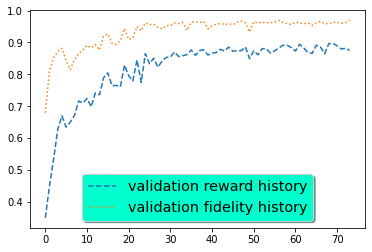


测试中, 请稍等...
测试集平均保真度为： 0.9698000881025609
测试时间所用为:  481.3775124549866


<Figure size 432x288 with 0 Axes>

In [8]:
%run ./src/Two-qubit_QSR_via_DRL.py 

上图也就是原文中的 图4(b)，且最终测试集的平均保真度达到了0.9698。可见，在此模型下，复现结果和原文中一致。

# 项目总结：

本项目依托 Mindspore 和 MindQuantum  复现了此论文最核心的两项结果：通过充足的训练，可设计最佳的时序脉冲以实现在半导体双量子点系统下，单和双量子比特任意态的重置任务。此项目展示了 Mindspore 和 MindQuantum 可以很好地完成量子系统优化控制设计任务。例证了 MindQuantum 在含时控制下的量子态模拟中具有很大的适用空间。